In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.sparse import diags
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
plt.rcParams.update({'font.size': 14})
import os, sys
import time

def calcvelocity(rrange,sigma,vdiff,A,vmin):         #Calculate the introduced velocity profile
    sigmaterm = sigma**2
    distances = np.linspace(0,rrange,Nx)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vactive*vdiff*np.exp(-I/A)+vmin, I

def normalize(inn):                                  #normalize the input curve to 1
    return inn/(sum(inn)*dx)

def calcvelocitysingle(rvalue,sigma,vdiff,A,vmin):   #Calculate the introduced velocity profile at a single position
    sigmaterm = 2*sigma**2
    I = A*np.exp(-rvalue**2/sigmaterm)
    return vdiff*np.exp(-I/A)+vmin

def MSD(t,D,V,taur):                    #Calculate the steplength
    return 4*D*t+V**2*taur**2/2*(2*t/taur+np.exp(-2*t/taur)-1)

def steplengththeory(t,v,taur):
    return v*t*(1-t/taur)

# Initial parameters for theory

In [59]:
amplitude = 1                    #Amplitude, always 1
vmin = 0                         #Min velocity
vmax = 1                         #Max velocity
pxtomum=0.0533#e-6               #px to µm [µm/px]
sigma = 50*pxtomum               #Sigma for the Gaussian intensity profile [px]
D_0 = 3.85e-14*1e12              #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
boundaryradius = pxtomum * 200   #Size of the arena
vactive = 6                      #Active velocity

videosize = 800                  #size of the movie
programtime = 3                  #time of the program (tracking + calculation) [s]
iterationtime = 51.9986          #iteration time in ms

delayincrease = 4                #delay increase per step
vprofilesteps = 50               #radial start points                               
steps = 180                       #angular steps
number = 10                      #delay steps
boundaryparameter = 0.5          #parameter defining the strength of the influence of the boundary bounce
driftparameter = 0.4             #parameter defining the strength of the drift
savefolder = '.'

dt = 0.05
howlong = 5
alldata = np.zeros((howlong,2))
count1=1;count2=0
tauwave = [0.2,0.4,0.65,0.85,1.05]
for i in range(howlong):
    alldata[i,0] = i
    alldata[i,1] = tauwave[i]

# Perform theory

In [60]:
vdiff = vmax - vmin
addtime = videosize*1.9176e-6+(1032/27e6+1.9176e-6)*videosize+programtime*1e-3+1e-3*2
dt = iterationtime*1e-3
onestep = 360/steps
rwave = np.linspace(0,boundaryradius,vprofilesteps,endpoint=True)
dx = rwave[1] - rwave[0]
maxdelay = 1+delayincrease*number
values = np.zeros(number); delayarray = np.zeros(number)
for i in range(number):                  #calculate the delay for the different steps
    values[i] = 1 + delayincrease*i
    delayarray[i] = iterationtime*1e-3*(values[i]-1)+dt/2+videosize*1.9176e-6+(1032/27e6+1.9176e-6)*videosize+programtime*1e-3+1e-3*2 

dataimportant = np.zeros((6,number*howlong))
dataradial = np.zeros((vprofilesteps,5,number*howlong))
string_temp = savefolder + '/DataGeneral/'
if not os.path.exists(string_temp): os.makedirs(string_temp)       #0  1              2    3    4     5   6       7                 8    
np.savetxt(string_temp + 'DataGeneral'+str(boundaryparameter)+'.txt', np.transpose([dt,boundaryradius,vmin,vmax,sigma,D_0,vactive,boundaryparameter,driftparameter]),fmt='%1.6f')
    
saveimportantsteps = np.zeros((number,vprofilesteps,steps,4,howlong))
calctime = 0
for m in range(howlong):
    start_time = time.time() 
    taur = alldata[m,1] 

    everystep = np.zeros((maxdelay,vprofilesteps,steps,4))                    #every step on the path to the past position is saved
    importantsteps = np.zeros((number,vprofilesteps,steps,4))                 #just the steps of the wanted delays are saved
    everystep[0,:,:,0] = 0
    for i in range(vprofilesteps): everystep[0,i,:,1] = rwave[i]              #radial startposition
    for i in range(steps): everystep[:,:,i,2] = onestep*i                     #angular startposition
    for i in range(vprofilesteps):
        for j in range(steps):
            count = 0
            for p in range(1,maxdelay+1):
                dist = np.sqrt(pow(everystep[p-1,i,j,0],2)+pow(everystep[p-1,i,j,1],2))    #dist to center for every position
                if dist >= boundaryradius:                                                 #boundary condition - reflexion of v-profile
                    dist = 2*boundaryradius - boundaryparameter*dist                       #v-profile is mirrored at the boundary
                everystep[p-1,i,j,3] = vactive*calcvelocitysingle(dist,sigma,vdiff,amplitude,vmin)  #calculate v for every position
                step = steplengththeory(dt,everystep[p-1,i,j,3],taur)                  #caclculate step length for every position
                if p < maxdelay:
                    everystep[p,i,j,0] = everystep[p-1,i,j,0] + np.cos(everystep[p-1,i,j,2]*np.pi/180)*step   #calculate new position
                    everystep[p,i,j,1] = everystep[p-1,i,j,1] + np.sin(everystep[p-1,i,j,2]*np.pi/180)*step
                if count < number:                                           #save just important steps
                    if p-1 == values[count]:
                        importantsteps[count,i,j,:4] = everystep[p-1,i,j,:4]
                        count += 1
    #print(importantsteps[1,1,1,:])
    saveimportantsteps[:,:,:,:,m] = importantsteps[:,:,:,:]
    #print(saveimportantsteps[1,1,1,:,m])

    vprofiles = np.zeros((number,vprofilesteps,4))
    for i in range(number):
        for j in range(vprofilesteps):
            vprofiles[i,j,0] = np.mean(importantsteps[i,j,:,3])                        #calculate v profile
            vprofiles[i,j,1] = np.mean(importantsteps[i,j,int(vprofilesteps/2):,3])    #v moving outwards
            vprofiles[i,j,2] = np.mean(importantsteps[i,j,:int(vprofilesteps/2),3])    #v moving inwards
            vprofiles[i,j,3] = vprofiles[i,j,2] - vprofiles[i,j,1]                     #v difference

    savedensity2 = np.zeros((vprofilesteps,number))             #solve the ODe to get the density from the D- and v_diff profiles
    for k in range(number):
        Darray = np.zeros(vprofilesteps)
        Darray = D_0+vprofiles[k,:,0]**2*taur/4# + D_0
        c = np.zeros(vprofilesteps)                             #array to save the density distributions
        c[0] = 1
        for i in range(0,vprofilesteps-1):
            c[i+1] = c[i] * (1 - dx/Darray[i]*((Darray[i+1]-Darray[i])/(2*dx)+driftparameter*vprofiles[k,i,3]))
            c[:] = c[:]/sum(abs(c[:])*dx)                       #Normalize
        savedensity2[:,k] = c                                   #saveit

    maxpoints = np.zeros((number,2))
    for i in range(number):                                     #find and save maximum points of the drift for every delay
        maxpoints[i,1] = max(vprofiles[i,:,3])
        check = np.argmax(vprofiles[i,:,3])
        maxpoints[i,0] = rwave[check]
        
    dataend = 3.553 #mittel zwischen 2-3            
    theodensity = np.zeros(number)                            #Calculate the percentage the particle spends in the inner quarter
    count = 0; check = True                                   #Theory
    while check == True:
        if rwave[count] >= dataend: 
            check = False
            theoend = count
        else: count += 1
    for i in range(number): theodensity[i] = sum(savedensity2[:theoend,i]*dx)/sum(savedensity2[:,i]*dx)
        
    string_temp = savefolder + '/PlotOverview-pdf/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    string_temp2 = savefolder + '/PlotOverview-svg/'
    if not os.path.exists(string_temp2): os.makedirs(string_temp2)
    fig, ax = plt.subplots(figsize=(15,10)) 
    fig.suptitle(r'$\tau_{r} = $'+str(taur)+' s - boundary factor = '+str(boundaryparameter), fontsize=16)

    ax1 = plt.subplot(2,2,1)                  #plot rings
    colorwave = cm.plasma(np.linspace(0, 1, vprofilesteps))
    circle2 = plt.Circle((0, 0), boundaryradius, color='k',linestyle='--', fill=False)
    ax1.add_artist(circle2)
    test = 6
    for i in range(vprofilesteps):
        if i % 6 == 0:
            ax1.scatter(rwave[i],0,color='k')
            ax1.plot(importantsteps[test,i,:,1],importantsteps[test,i,:,0],c=colorwave[i])
            ax1.plot([importantsteps[test,i,-1,1],importantsteps[test,i,0,1]],[importantsteps[test,i,-1,0],importantsteps[test,i,0,0]],c=colorwave[i])
    ax1.set_aspect('equal')
    value = 1.1*boundaryradius
    ax1.set_xlabel('x [µm]')
    ax1.set_ylabel('y [µm]')
    ax1.set_xlim([-4,18])
    ax1.set_ylim([-8,8])
    ax1.set_title('Travel circles')

    ax2 = plt.subplot(2,2,2)                  #plotv profiles
    colorwave = cm.plasma(np.linspace(0, 1, number))
    for i in range(number): ax2.plot(rwave,vprofiles[i,:,0],color=colorwave[i],label = 'delay = '+str(round(delayarray[i],2))+'s')
    ax2.set_xlabel('Distance to center [µm]')
    ax2.set_ylabel('Velocity [µm/s]') 
    ax2.set_title('Velocity profiles')
    ax2.set_xlim(0,boundaryradius)
    ax2.set_ylim([2,6])

    plt.tight_layout() 
    data = np.linspace(delayarray[0], delayarray[-1], number).reshape(number, 1)
    im = ax.imshow(data, cmap='plasma')       #plot the colorbar
    divider = make_axes_locatable(ax2)
    cax = fig.add_axes([0.9, 0.6, 0.02, 0.2])
    plt.colorbar(im, cax=cax)
    plt.text(0.8,2,r'$\delta$ [s]')

    ax3 = plt.subplot(2,2,3)                  #plot v_diff and maximum points                                                                     
    for i in range(number):
        ax3.plot(rwave,vprofiles[i,:,3],color=colorwave[i])
        ax3.scatter(maxpoints[i,0],maxpoints[i,1],s=80,color=colorwave[i])
    ax3.plot(maxpoints[:,0],maxpoints[:,1],color='k',linestyle='--',label = 'Maximum points')
    ax3.set_xlabel('Distance to center [µm]')
    ax3.set_ylabel('Velocity difference [µm/s]')
    ax3.set_title('Drift')
    ax3.set_xlim(0,boundaryradius)
    ax3.set_ylim([0,1.35])
    ax3.legend()

    ax4 = plt.subplot(2,2,4)                  #plot resulting density distributions
    for i in range(number): ax4.plot(rwave,savedensity2[:,i],c=colorwave[i])
    ax4.set_xlabel('Distance to center [µm]')
    ax4.set_ylabel('Density') 
    ax4.set_title('Resulting density from ODE')
    ax4.set_xlim(0,boundaryradius)
    ax4.set_ylim([0,1.05*np.amax(savedensity2)])
    ax4.set_ylim([0,0.4])

    plt.savefig(string_temp+'Overview - boundary factor = '+str(boundaryparameter)+' - taur = '+str(round(taur,2))+'.pdf', format='pdf')
    plt.savefig(string_temp2+'Overview - boundary factor = '+str(boundaryparameter)+' - taur = '+str(round(taur,2))+'.svg', format='svg')
    plt.close(fig)#show()    
        
    dataimportant[0,m*number:m*number+number] = taur * np.ones(number)
    dataimportant[1,m*number:m*number+number] = values
    dataimportant[2,m*number:m*number+number] = delayarray
    dataimportant[3,m*number:m*number+number] = theodensity
    dataimportant[4,m*number:m*number+number] = maxpoints[:,0]
    dataimportant[5,m*number:m*number+number] = maxpoints[:,1]
        
    count = 0
    for i in range(m*number,m*number+number):
        dataradial[:,0,i] = rwave
        dataradial[:,1,i] = vprofiles[count,:,0]
        dataradial[:,2,i] = vprofiles[count,:,3]
        dataradial[:,3,i] = savedensity2[:,count]
        count += 1
        
    print('tau_R = '+str(taur)+' s')
    print("--- %s seconds ---" % round((time.time() - start_time),2))
    calctime += round((time.time() - start_time),2)
print('Total duration: ',calctime,' s')
np.savetxt('DataImportant.txt', alldata,fmt='%1.6f')
np.savetxt('DataRadial.txt', alldata,fmt='%1.6f')

tau_R = 0.2 s
--- 11.02 seconds ---
tau_R = 0.4 s
--- 12.24 seconds ---
tau_R = 0.65 s
--- 12.18 seconds ---
tau_R = 0.85 s
--- 11.35 seconds ---
tau_R = 1.05 s
--- 10.68 seconds ---
Total duration:  57.47  s


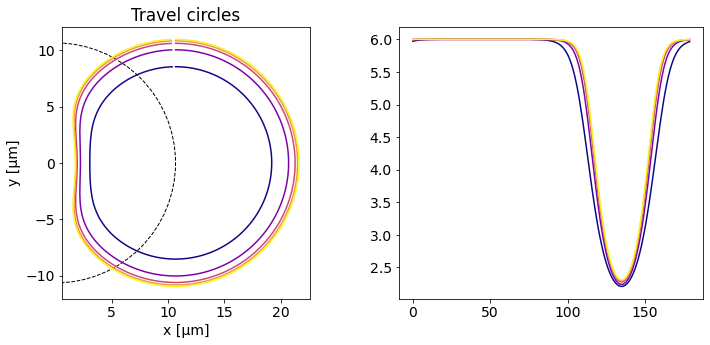

In [55]:
fig, ax = plt.subplots(figsize=(12,5))        
colorwave = cm.plasma(np.linspace(0, 1, howlong))
ax1 = plt.subplot(1,2,1)

circle2 = plt.Circle((0, 0), boundaryradius, color='k',linestyle='--', fill=False)
ax1.add_artist(circle2)
for i in range(howlong):
    #ax1.scatter(rwave[i],0,color='k')
    ax1.plot(saveimportantsteps[-1,-1,:,1,i],saveimportantsteps[-1,-1,:,0,i],c=colorwave[i])
    #ax1.plot([importantsteps[test,i,-1,1],importantsteps[test,i,0,1]],[importantsteps[test,i,-1,0],importantsteps[test,i,0,0]],c=colorwave[i])
ax1.set_aspect('equal')
value = 1.1*boundaryradius
ax1.set_xlabel('x [µm]')
ax1.set_ylabel('y [µm]')
#ax1.set_xlim([-4,18])
#ax1.set_ylim([-8,8])
ax1.set_title('Travel circles')

ax2 = plt.subplot(1,2,2)
for i in range(howlong):
    ax2.plot(saveimportantsteps[-1,20,:,3,i],c=colorwave[i])

<ipython-input-56-a90e0ecf8574>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


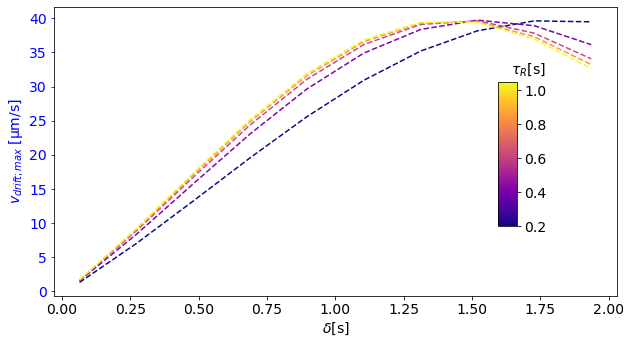

In [56]:
test = np.zeros((howlong*number))
for i in range(howlong*number):
    test[i] = sum(dataradial[:,2,i])

fig, ax = plt.subplots(figsize=(9,5))        
colorwave = cm.plasma(np.linspace(0, 1, howlong))
ax1 = plt.subplot(1,1,1)
#line1 = ax1.plot(delaywave2,vdrift, color='b',linestyle='--',label=r'$\sum {v_{\rm{in}} - v_{\rm{out}}}$')#/max(vdrift)
for m in range(howlong):
    line1 = ax1.plot(dataimportant[2,m*number:(m+1)*number],test[m*number:(m+1)*number], color=colorwave[m],linestyle='--',label=r'$v_{\rm{total \: drift}}$')#/max(vdrift)
ax1.set_xlabel(r'$\delta [\rm{s}]$')#
ax1.set_ylabel(r'$v_{drift; max}$ [µm/s]', color='b')
ax1.tick_params('y', colors='b')

data = np.linspace(alldata[0,1], alldata[-1,1], howlong).reshape(howlong, 1)
im = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax2)
cax = fig.add_axes([0.78, 0.35, 0.03, 0.4])
plt.colorbar(im, cax=cax)
plt.text(0.8,1.1,r'$\tau_{R} [\rm{s}]$')

plt.tight_layout()
#plt.savefig('Drift all shell 7.svg', format='svg')
plt.show()

<ipython-input-57-04f7ef371339>:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


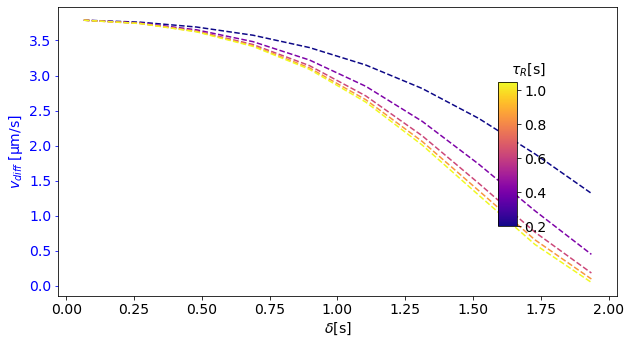

In [57]:
fig, ax = plt.subplots(figsize=(9,5))        
colorwave = cm.plasma(np.linspace(0, 1, howlong))
ax1 = plt.subplot(1,1,1)
for m in range(howlong):
    line1 = ax1.plot(dataimportant[2,m*number:(m+1)*number],dataradial[-1,1,m*number:(m+1)*number]-dataradial[0,1,m*number:(m+1)*number], color=colorwave[m],linestyle='--',label=r'$v_{\rm{total \: drift}}$')#/max(vdrift)
ax1.set_xlabel(r'$\delta [\rm{s}]$')#
ax1.set_ylabel(r'$v_{diff}$ [µm/s]', color='b')
ax1.tick_params('y', colors='b')

data = np.linspace(alldata[0,1], alldata[-1,1], howlong).reshape(howlong, 1)
im = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax2)
cax = fig.add_axes([0.78, 0.35, 0.03, 0.4])
plt.colorbar(im, cax=cax)
plt.text(0.8,1.1,r'$\tau_{R} [\rm{s}]$')

plt.tight_layout()
#plt.savefig('Velocitydiff.svg', format='svg')
plt.show()

<ipython-input-58-3545482932ad>:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


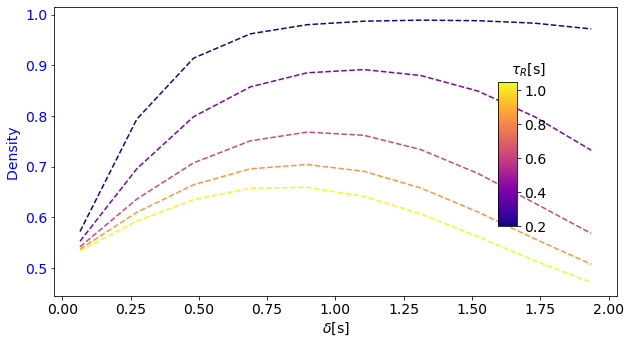

In [58]:
fig, ax = plt.subplots(figsize=(9,5))        
colorwave = cm.plasma(np.linspace(0, 1, howlong))
ax1 = plt.subplot(1,1,1)
for m in range(howlong):
    line1 = ax1.plot(dataimportant[2,m*number:(m+1)*number],dataimportant[3,m*number:(m+1)*number], color=colorwave[m],linestyle='--',label=r'$v_{\rm{total \: drift}}$')#/max(vdrift)
ax1.set_xlabel(r'$\delta [\rm{s}]$')#
ax1.set_ylabel('Density ', color='b')
ax1.tick_params('y', colors='b')

data = np.linspace(alldata[0,1], alldata[-1,1], howlong).reshape(howlong, 1)
im = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax2)
cax = fig.add_axes([0.78, 0.35, 0.03, 0.4])
plt.colorbar(im, cax=cax)
plt.text(0.8,1.1,r'$\tau_{R} [\rm{s}]$')

plt.tight_layout()
#plt.savefig('Density.svg', format='svg')
plt.show()